In [1]:
import os
import re 
import numpy as np 
import pandas as pd
import seaborn as sns 
from collections import Counter
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
plt.style.use('ggplot')
# import xgboost as xgb

In [2]:
ROOT_DIR = "./dataset"
FILE = "listings.csv"
FILE_PATH = os.path.join(ROOT_DIR, FILE)

# Overview of the data 

In [3]:
def load_data(PATH=FILE_PATH):
    return pd.read_csv(PATH)

df = load_data()

In [4]:
print(df.info())
print("Different data types:")
print(Counter(list(df.dtypes)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45815 entries, 0 to 45814
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45815 non-null  int64  
 1   listing_url                                   45815 non-null  object 
 2   scrape_id                                     45815 non-null  int64  
 3   last_scraped                                  45815 non-null  object 
 4   source                                        45815 non-null  object 
 5   name                                          45813 non-null  object 
 6   description                                   44894 non-null  object 
 7   neighborhood_overview                         26751 non-null  object 
 8   picture_url                                   45815 non-null  object 
 9   host_id                                       45815 non-null 

## Relevant Columns and Rows 

First, we note that we wil only be dealing with Airbnb listings in the City of Los Angeles, therefore, we filter out the rows including details of properties from other cities. We see that the `neighbourhood_group_cleansed` variable contains information on the city level.

In [5]:
df.loc[:, "neighbourhood_group_cleansed"].value_counts()

City of Los Angeles     19501
Other Cities            14849
Unincorporated Areas     3576
Name: neighbourhood_group_cleansed, dtype: int64

In [6]:
la_df = df[df.loc[:, "neighbourhood_group_cleansed"] == "City of Los Angeles"]
la_df.reset_index(drop=True, inplace=True)

`la_df` will hence be the relevant subset of data that we will perform our analysis on.

Next, we broadly look at some of the features that will be relevant for our analyses. Once we have a smaller subset of features to work with, we can then move on to preparing our data for our machine learning models.

1. Firstly, we will remove the columns that just have metadata information about the listings such as host_id, url, images, date at which the listing was scraped since these columns do not contribute anything meaningful to our analysis.

In [7]:
filtered_cols = ["id", "name", "host_id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", "host_url", "host_thumbnail_url", "host_picture_url",
                "calendar_updated", "calendar_last_scraped", "description", "neighborhood_overview", "host_about", "host_since",
                "host_name", "host_location", "host_has_profile_pic", "host_neighbourhood","last_review", "first_review"]
la_df_filtered = la_df.drop(columns=filtered_cols).copy()
la_df_filtered.shape

(19501, 52)

2. Secondly, we consider columns that have a huge proportion of NULL values and hence will not be able to add meaningful information to our analyses.

In [8]:
na_list = la_df_filtered.isna().sum()[lambda x: x > 0].sort_values(ascending=False)
print(na_list)
print(f"Number of NA Columns: {len(na_list)}")

bathrooms                      19501
license                        11741
neighbourhood                   7769
review_scores_value             5699
review_scores_location          5698
review_scores_checkin           5697
review_scores_accuracy          5693
review_scores_communication     5692
review_scores_cleanliness       5692
reviews_per_month               5545
review_scores_rating            5545
host_response_rate              4984
host_response_time              4984
host_acceptance_rate            4604
bedrooms                        2197
beds                             452
host_is_superhost                 52
bathrooms_text                    44
minimum_minimum_nights             2
minimum_maximum_nights             2
maximum_maximum_nights             2
minimum_nights_avg_ntm             2
maximum_nights_avg_ntm             2
host_identity_verified             2
host_total_listings_count          2
host_listings_count                2
maximum_minimum_nights             2
d

Here, we see that 27 columns have at least one NA value. Some columns such as bathrooms and license, host_response_rate, host_response_time, host_acceptance_rate have too many NULL values (and are difficult to impute for) to make any relevant impact on our analyses. Therefore, we get rid of them entirely. For the neighbourhood column, we see that we have a more relevant column called neighbourhood_cleansed that has far fewer NULL values. For the review columns, we can try imputation strategies to overcome the NULL value issue. Lastly, there are other columns such as maximum_minimum_nights, host_listings_count etc that may be replaced by other more pertinent columns/removed entirely.

In [9]:
relevant_cols = ['host_is_superhost', 'host_total_listings_count', 'host_verifications', 'host_identity_verified',
                'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type',
                'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
                'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
                'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
                'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable',
                'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                'reviews_per_month']
la_df_na = la_df_filtered.loc[:, relevant_cols]
la_df_na.head(3)

,host_is_superhost,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,f,3.0,"['email', 'phone']",f,Venice,City of Los Angeles,33.99211,-118.47600,Entire rental unit,Entire home/apt,...,5.00,5.00,5.00,5.00,f,2,2,0,0,0.02
1,f,2.0,"['email', 'phone']",t,Atwater Village,City of Los Angeles,34.12206,-118.26783,Entire bungalow,Entire home/apt,...,4.89,4.85,4.95,4.76,f,2,2,0,0,0.98
2,f,2.0,"['email', 'phone', 'work_email']",t,Venice,City of Los Angeles,33.97487,-118.46312,Entire rental unit,Entire home/apt,...,4.78,4.93,4.89,4.85,t,1,1,0,0,0.22


Now with these 39 columns, we will make our final data subset by considering correlations of these columns with the target variable 'price' and also amongst themselves to make sure that we select features that have a high influence on price and are also not very correlated with each other to reduce the risk redundancy and poor performance.

However, to do this, we will need to clean some of the features as well as the target variable to transform them into a numeric format, ready for our machine learning models. 

# Data Cleaning

In [11]:
la_df_na['price']

0        $152.00
1         $75.00
2        $125.00
3        $189.00
4         $85.00
          ...   
19496    $500.00
19497    $109.00
19498    $274.00
19499    $317.00
19500     $98.00
Name: price, Length: 19501, dtype: object

First, we will clean up the `price` column and transform it into a numeric format. 

In [12]:
def clean_price(x):
    x = x.split("$")[1]
    x = re.sub(",", "", x)
    return float(x)

la_df_na['price'] = la_df_na['price'].apply(clean_price)
la_df_na['price']

0        152.0
1         75.0
2        125.0
3        189.0
4         85.0
         ...  
19496    500.0
19497    109.0
19498    274.0
19499    317.0
19500     98.0
Name: price, Length: 19501, dtype: float64

We also see that there are certain rows where the price = 0. We remove these rows from our data. 

In [13]:
la_df_na = la_df_na[la_df_na['price'] != 0]
la_df_na.reset_index(drop=True, inplace=True)

In [14]:
# test = la_df_na.copy()
# test = test[test['price'] <= 10000]
# sns.histplot(np.log(test['price']))

In [15]:
# sns.histplot(np.log(la_df_na.price))

In [16]:
# la_df_na = la_df_na[(la_df_na['price'] != 0) & (np.log(la_df_na['price']) >= 3) & (np.log(la_df_na['price']) <= 6.5)]
# la_df_na = la_df_na[(la_df_na['price'] != 0)]
# la_df_na.reset_index(drop=True, inplace=True)

Removing hotel rooms

In [17]:
la_df_na = la_df_na[la_df_na['room_type'] != 'Hotel room']

In [18]:
# Neighbourhoods

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


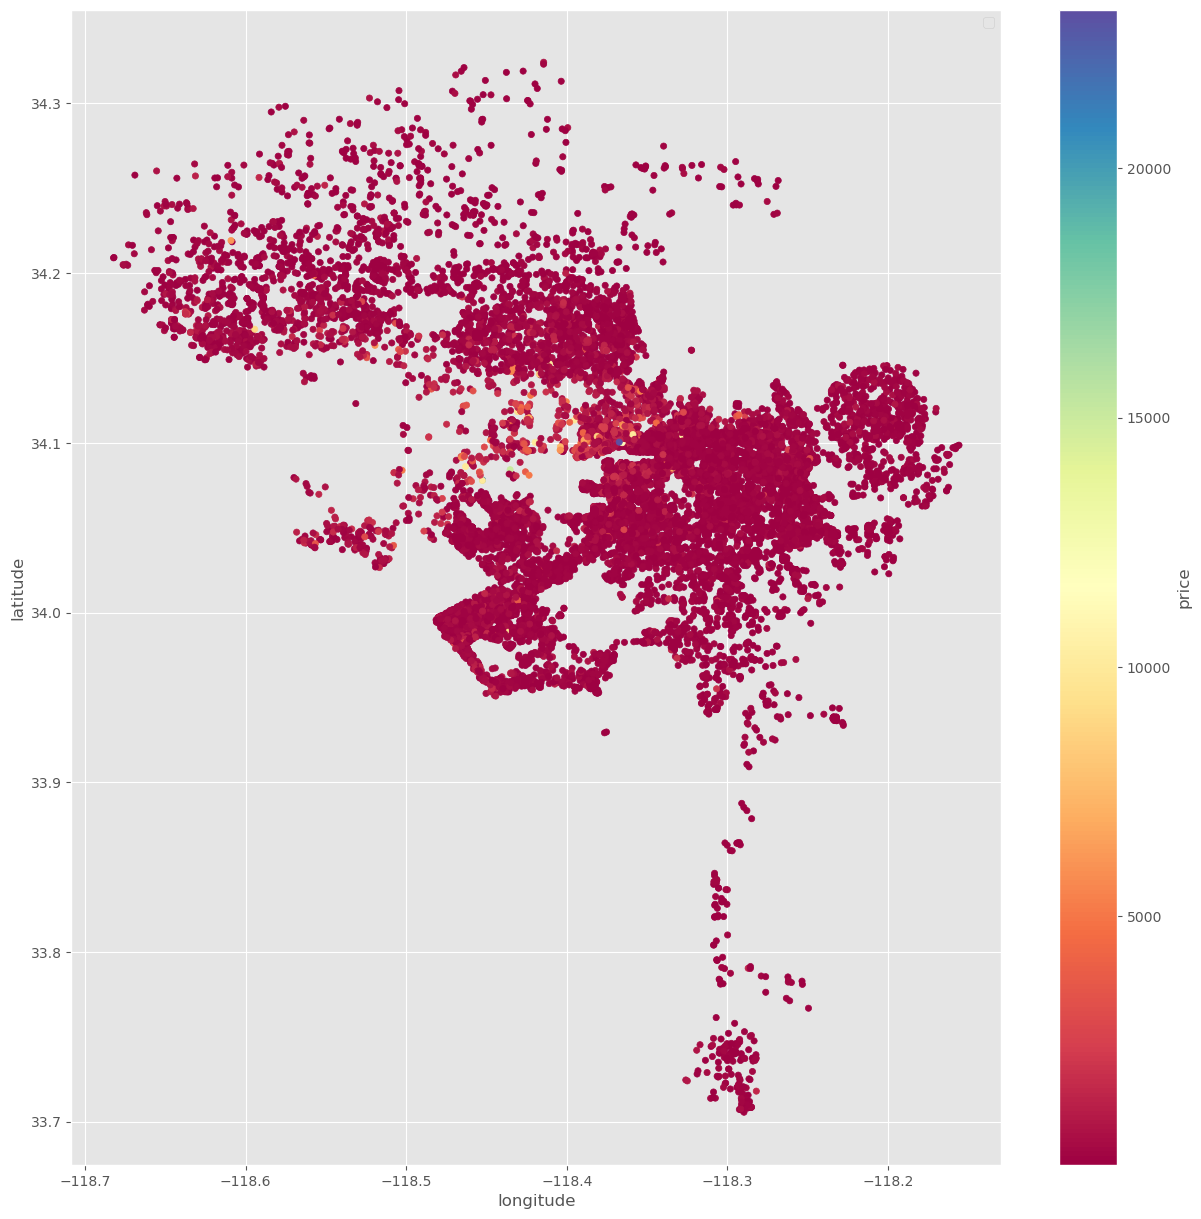

In [19]:
la_df_na.plot(kind="scatter", x="longitude", y="latitude", alpha=1.0,figsize=(15,15),
c="price", cmap=plt.get_cmap("Spectral"), colorbar=True,
)
plt.legend()

we see that there is a horizontal strip that has high values for listings. So, we will try to include the neighbourhood column for our analysis and keep those that have at least 50 listings.

In [20]:
# filter_df = la_df_na.groupby('neighbourhood_cleansed')['neighbourhood_cleansed'].count() > 50
# filtered_neighbourhoods = filter_df.index[filter_df.values == True]

In [21]:
# la_df_na = la_df_na[la_df_na['neighbourhood_cleansed'].isin(filtered_neighbourhoods.values)]

In [22]:
# la_df_neighbourhoods = pd.get_dummies(la_df_na['neighbourhood_cleansed'], prefix='neighbourhood')
# la_df_neighbourhoods = pd.concat([la_df_na, la_df_neighbourhoods], axis=1)
# la_df_na = la_df_neighbourhoods.copy()

Next, we look at processing the different features in a relevant manner. 

* Converting the boolean columns into 0 and 1 

In [23]:
def f(x):
    return 1 if x == 't' else 0
la_df_na['host_is_superhost'] = la_df_na['host_is_superhost'].apply(f)
la_df_na['host_identity_verified'] = la_df_na['host_identity_verified'].apply(f)
la_df_na['has_availability'] = la_df_na['has_availability'].apply(f)
la_df_na['instant_bookable'] = la_df_na['instant_bookable'].apply(f)

<AxesSubplot:xlabel='instant_bookable', ylabel='price'>

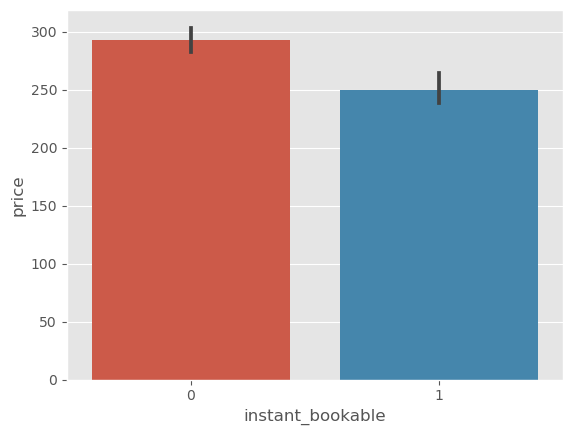

In [24]:
sns.barplot(data=la_df_na, x='instant_bookable', y='price')

In [25]:
import researchpy as rp
import scipy.stats as stats

summary, results = rp.ttest(group1= la_df_na['price'][la_df_na['instant_bookable'] == 0], group1_name= "Not Instantly Bookable",
         group2= la_df_na['price'][la_df_na['instant_bookable'] == 1], group2_name= "Instantly Bookable")
print(results)

# can also see this from CI not overlapping

                                  Independent t-test     results
0  Difference (Not Instantly Bookable - Instantly...     42.3078
1                              Degrees of freedom =   19472.0000
2                                               t =       4.5713
3                           Two side test p value =       0.0000
4                          Difference < 0 p value =       1.0000
5                          Difference > 0 p value =       0.0000
6                                       Cohen's d =       0.0684
7                                       Hedge's g =       0.0684
8                                  Glass's delta1 =       0.0655
9                                Point-Biserial r =       0.0327


/Users/qasimr97/opt/anaconda3/envs/ml/lib/python3.10/site-packages/researchpy/ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


* For host verifications, we simply consider the number of different verifications a host has. 

In [26]:
def num_verifications(verifications):
    verifications = verifications[1:-1].split(',')
    try:
        verifications = list(map(lambda x: x.split("'")[1], verifications))
    except:
        verifications = []
    return len(verifications)

la_df_na['host_num_verifications'] = la_df_na['host_verifications'].apply(num_verifications)

* We gather information on the number of bathrooms in a property through the bathroom text.

In [27]:
def split(x):
    x = str(x)
    x = x.split()[0]
    if x == "Half-bath" or x == "Shared":
        x = 0.5
    elif x == "Private":
        x = 1
    return float(x)

la_df_na['number_of_bathrooms'] = la_df_na['bathrooms_text'].apply(split)

* We are given data on both the property and room types. However, we see that the `room_type` feature captures the general description and divides the properties into 4 main types. We also see that there is quite a distinction in airbnb prices based on this variable. Hence, we just consider `room_type` as a relevant feature instead of `property_type`. 

* However, given that `room_type` is a categorical variable, we will convert this into numeric form by transforming it using OneHotEncoding and remove the original column.

<AxesSubplot:xlabel='room_type', ylabel='price'>

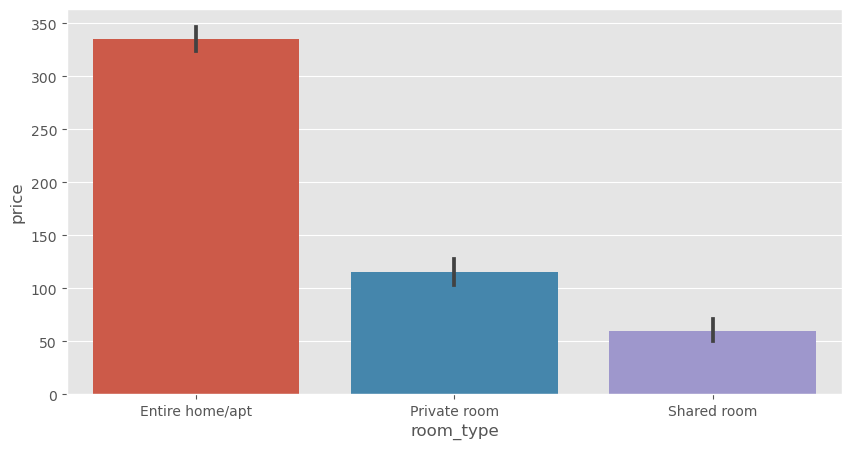

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(data=la_df_na, x='room_type', y='price')

In [29]:
ohe_df = pd.get_dummies(la_df_na.room_type, prefix='Room')
la_df_ohe = pd.concat([la_df_na, ohe_df], axis=1)
la_df_ohe.drop(['room_type'],axis=1, inplace=True)

* We consider the number of amenities offered at a property as our amenities feature

In [30]:
# def num_amenities(amenities):
#     amenities = amenities[1:-1].split(',')
#     try:
#         amenities = list(map(lambda x: x.split('"')[1], amenities))
#     except:
#         amenities = []
#     return len(amenities)
# la_df_ohe['number_of_amenities'] = la_df_ohe['amenities'].apply(num_amenities)

In [31]:
amenities = la_df_ohe['amenities']
amenities_count =[]
for ele in amenities:
    ele = len(ele.split(','))
    amenities_count.append(ele)
la_df_ohe['number_of_amenities'] = amenities_count

* For the availability and reviews features, we consider those that give a more recent representation. Hence, we choose the `availability_60` and `number_of_reviews_l30d` columns.

* For the review scores, we note that all of the relevant features are pretty highly correlated. Hence, we decide to create one `review_scores_average` column that considers the row-wise average of the pertinent columns.

In [32]:
review_cols = la_df_ohe.filter(like='review_scores').columns
la_df_ohe[review_cols] = la_df_ohe.filter(like='review_scores').fillna(value=0)
# la_df_ohe.filter(like='review_scores').fillna(value=0)

In [33]:
la_df_ohe['review_scores_average'] = la_df_ohe.filter(like='review_scores').mean(axis=1)

In [34]:
la_df_ohe.filter(like='review').isna().sum()

number_of_reviews                 0
number_of_reviews_ltm             0
number_of_reviews_l30d            0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
reviews_per_month              5539
review_scores_average             0
dtype: int64

* For the actual listings, we just consider the `host_total_listings_count` column and ignore the rest.

In [35]:
la_df_ohe.columns

Index(['host_is_superhost', 'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       '

In [36]:
original_cols = ['host_is_superhost', 'host_total_listings_count', 'host_num_verifications', 'host_identity_verified',
                   'instant_bookable','latitude', 'longitude','neighbourhood_cleansed',
                'Room_Entire home/apt', 'Room_Private room', 'Room_Shared room', 'accommodates', 'number_of_bathrooms', 'bedrooms', 'beds', 'number_of_amenities', 'price', 'availability_60',
                  'number_of_reviews_l30d', 'review_scores_average']
# cleaned_columns.append(neighbourhood_cols)
la_df_cleaned = la_df_ohe.loc[:, original_cols].copy()
la_df_cleaned.head(2)

,host_is_superhost,host_total_listings_count,host_num_verifications,host_identity_verified,instant_bookable,latitude,longitude,neighbourhood_cleansed,Room_Entire home/apt,Room_Private room,Room_Shared room,accommodates,number_of_bathrooms,bedrooms,beds,number_of_amenities,price,availability_60,number_of_reviews_l30d,review_scores_average
0,0,3.0,2,0,0,33.99211,-118.47600,Venice,1,0,0,2,1.0,2.0,2.0,22,152.0,0,0,4.905714
1,0,2.0,2,1,0,34.12206,-118.26783,Atwater Village,1,0,0,2,1.0,1.0,1.0,30,75.0,2,0,4.772857


In [37]:
la_df_cleaned.isna().sum()

host_is_superhost               0
host_total_listings_count       2
host_num_verifications          0
host_identity_verified          0
instant_bookable                0
latitude                        0
longitude                       0
neighbourhood_cleansed          0
Room_Entire home/apt            0
Room_Private room               0
Room_Shared room                0
accommodates                    0
number_of_bathrooms            32
bedrooms                     2186
beds                          442
number_of_amenities             0
price                           0
availability_60                 0
number_of_reviews_l30d          0
review_scores_average           0
dtype: int64

# Dealing with NA Values

We deal with the NULL values in our remaining, filtered columns in different ways. These are mentioned below:

1. We note that most values in the `review_scores_average` columns are in the 4-5 range. We fill in the NA values for this column by imputing the median.

<AxesSubplot:xlabel='review_scores_average', ylabel='Count'>

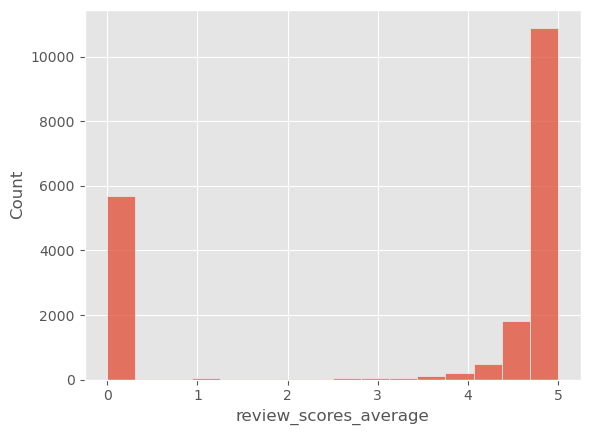

In [38]:
sns.histplot(data=la_df_cleaned, x='review_scores_average')

In [39]:
median_scores = la_df_cleaned['review_scores_average'].median()
la_df_cleaned['review_scores_average'].fillna(value=median_scores, inplace=True)

2. Next, we see that the number of bathrooms, bedrooms and beds are linked with the `accomodates` feature. Therefore, we fill in the NA values for these columns by using the mean of each of these variables, given the value for the `accomodates` variable.  

<AxesSubplot:xlabel='accommodates', ylabel='beds'>

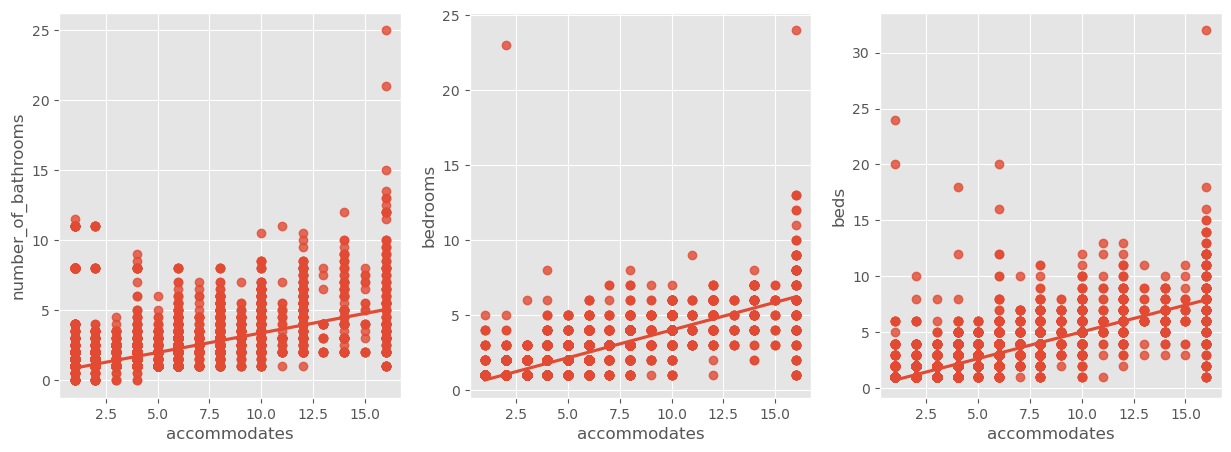

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

sns.regplot(ax = axes[0], data=la_df_cleaned, x='accommodates', y='number_of_bathrooms')
sns.regplot(ax = axes[1], data=la_df_cleaned, x='accommodates', y='bedrooms')
sns.regplot(ax = axes[2], data=la_df_cleaned, x='accommodates', y='beds')

In [41]:
la_df_cleaned['bedrooms'] = la_df_cleaned[['bedrooms', 'accommodates']].groupby('accommodates').transform(lambda x: round(x.fillna((x.mean()))))
la_df_cleaned['beds'] = la_df_cleaned[['beds', 'accommodates']].groupby('accommodates').transform(lambda x: round(x.fillna((x.mean()))))
la_df_cleaned['number_of_bathrooms'] = la_df_cleaned[['number_of_bathrooms', 'accommodates']].groupby('accommodates').transform(lambda x: round(x.fillna((x.mean()))))

In [42]:
# Finding correlations

Having preprocessed the relevant columns, we now find the top features that are most correlated with our target variable aka `price`. 

<AxesSubplot:>

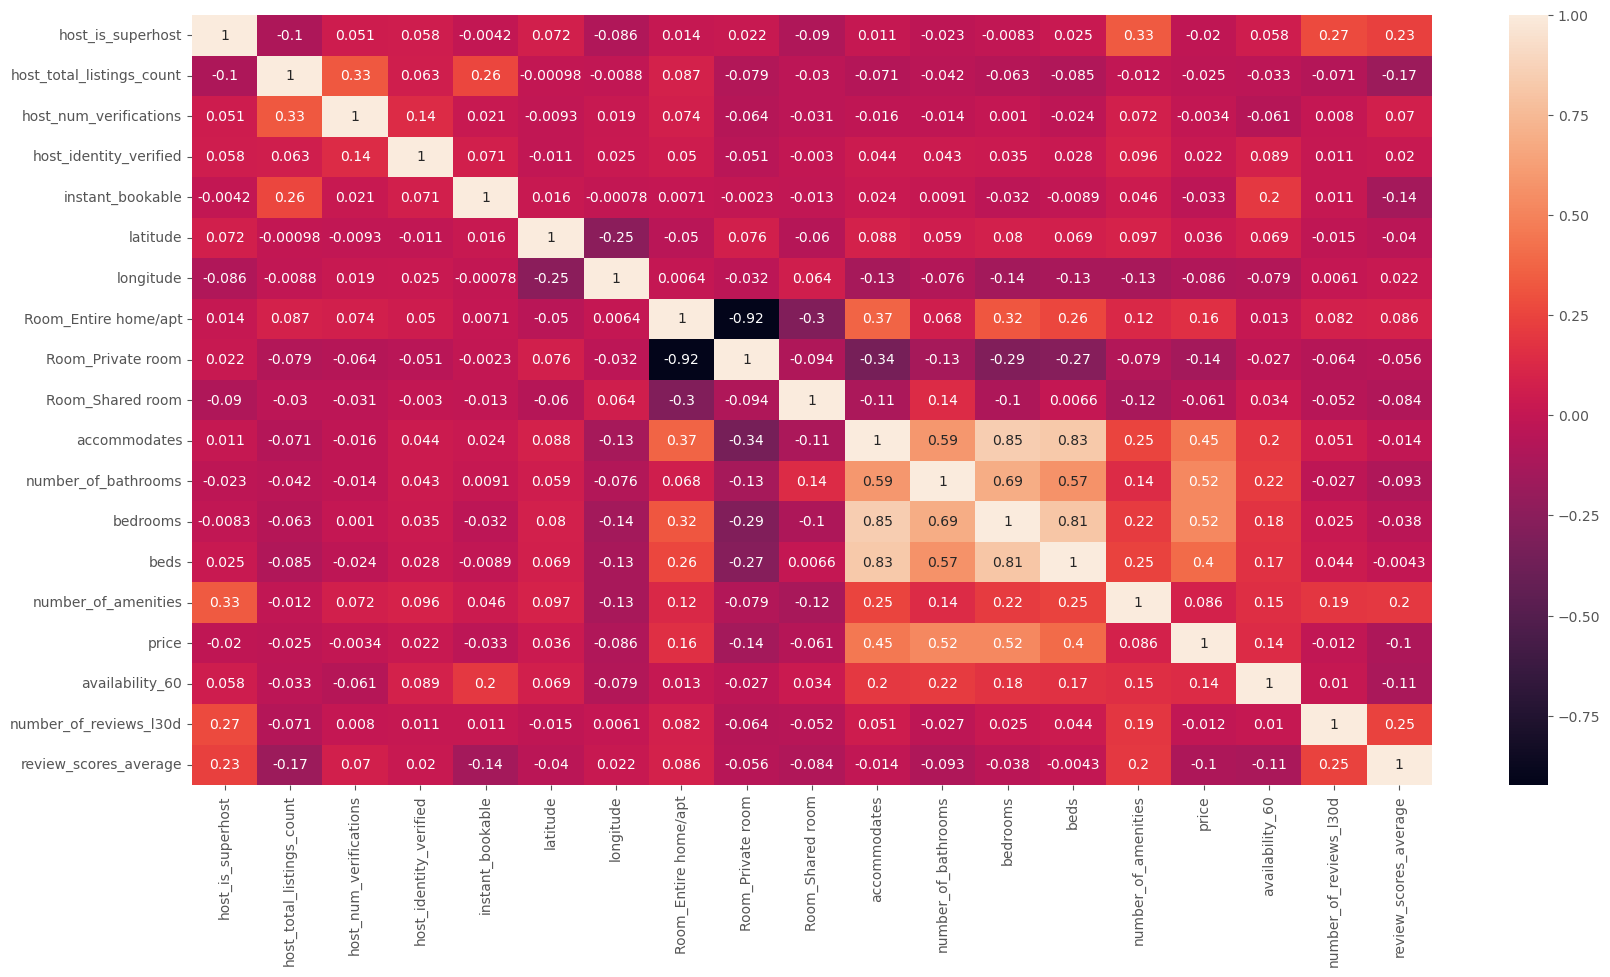

In [43]:

corr = la_df_cleaned[original_cols].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True)

In [44]:
corr["price"].sort_values(ascending=False)

price                        1.000000
bedrooms                     0.523846
number_of_bathrooms          0.522186
accommodates                 0.454171
beds                         0.404074
Room_Entire home/apt         0.159176
availability_60              0.142174
number_of_amenities          0.086138
latitude                     0.035990
host_identity_verified       0.022099
host_num_verifications      -0.003434
number_of_reviews_l30d      -0.011622
host_is_superhost           -0.019651
host_total_listings_count   -0.024708
instant_bookable            -0.032742
Room_Shared room            -0.060974
longitude                   -0.086500
review_scores_average       -0.100245
Room_Private room           -0.141396
Name: price, dtype: float64

In [45]:
la_df_cleaned.reset_index(drop=True,inplace=True)

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(la_df_cleaned, la_df_cleaned["neighbourhood_cleansed"]):
    strat_train_set = la_df_cleaned.loc[train_index]
    strat_test_set = la_df_cleaned.loc[test_index]

In [61]:
from sklearn.model_selection import train_test_split
cols_to_use = ['bedrooms', 'number_of_bathrooms', 'accommodates', 'beds', 'Room_Entire home/apt',
                          'availability_60', 'Room_Private room', 'Room_Shared room', 'longitude', 
                           'number_of_reviews_l30d','host_is_superhost', 'host_identity_verified',
               'latitude'
               , 'instant_bookable'] 
x = la_df_cleaned[cols_to_use]
y = la_df_cleaned['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [62]:
cols_to_use = ['bedrooms', 'number_of_bathrooms', 'accommodates', 'beds', 'Room_Entire home/apt',
                          'availability_60', 'Room_Private room', 'Room_Shared room', 'longitude', 
                           'number_of_reviews_l30d','host_is_superhost', 'host_identity_verified',
               'latitude'
               , 'instant_bookable'] 
# train_x = strat_train_set[['bedrooms', 'number_of_bathrooms', 'accommodates', 'beds', 'Room_Entire home/apt',
#                           'availability_60', 'Room_Private room', 'Room_Shared room', 'longitude', 
#                            'number_of_reviews_l30d']]
train_x = strat_train_set[cols_to_use]
train_y = np.log(strat_train_set[['price']])

train_x, train_y = train_x.reset_index(drop=True), train_y.reset_index(drop=True)
train_x

,bedrooms,number_of_bathrooms,accommodates,beds,Room_Entire home/apt,availability_60,Room_Private room,Room_Shared room,longitude,number_of_reviews_l30d,host_is_superhost,host_identity_verified,latitude,instant_bookable
0,3.0,1.0,3,1.0,1,0,0,0,-118.279800,0,0,1,33.926430,0
1,2.0,2.0,4,2.0,1,0,0,0,-118.443481,0,0,1,33.990092,1
2,4.0,3.0,6,6.0,1,60,0,0,-118.455370,0,0,1,33.999630,0
3,1.0,2.0,2,2.0,1,0,0,0,-118.415330,0,0,0,33.981070,0
4,4.0,2.0,1,1.0,0,16,1,0,-118.312100,0,1,1,34.087790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15574,3.0,2.0,6,3.0,1,0,0,0,-118.397469,0,0,1,34.195919,0
15575,1.0,1.0,2,1.0,1,60,0,0,-118.345760,0,0,1,34.103900,1
15576,1.0,1.0,2,1.0,1,0,0,0,-118.379910,0,0,1,33.970590,1
15577,3.0,2.0,6,3.0,1,5,0,0,-118.409790,0,0,1,33.987890,0


In [63]:
train_y

,price
0,3.688879
1,5.429346
2,6.214608
3,6.212606
4,3.891820
...,...
15574,5.298317
15575,5.703782
15576,5.370638
15577,5.799093


In [64]:
test_x = strat_test_set[cols_to_use]
test_y = strat_test_set[['price']]

test_x, test_y = test_x.reset_index(drop=True), test_y.reset_index(drop=True)
test_x

,bedrooms,number_of_bathrooms,accommodates,beds,Room_Entire home/apt,availability_60,Room_Private room,Room_Shared room,longitude,number_of_reviews_l30d,host_is_superhost,host_identity_verified,latitude,instant_bookable
0,1.0,1.0,2,1.0,0,35,1,0,-118.34263,5,0,1,34.092940,0
1,1.0,1.0,3,2.0,1,40,0,0,-118.60889,0,0,1,34.185097,0
2,6.0,8.0,14,6.0,1,58,0,0,-118.34758,0,0,1,34.119480,0
3,2.0,1.0,5,3.0,1,10,0,0,-118.33492,0,1,1,34.086400,0
4,1.0,1.0,4,2.0,1,16,0,0,-118.47897,0,0,1,33.994220,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,1.0,1.0,2,1.0,1,24,0,0,-118.37703,0,0,1,34.103470,1
3891,1.0,1.0,2,1.0,0,0,1,0,-118.45345,3,1,1,33.997070,0
3892,1.0,1.0,2,1.0,0,0,1,0,-118.40365,2,1,1,33.998080,0
3893,1.0,1.0,4,1.0,1,44,0,0,-118.34487,0,0,1,34.095000,1


In [65]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
train_y = np.log(y_train)
lin_reg.fit(X_train, train_y)
print(np.exp(train_y))

6074      95.0
965      400.0
8299     499.0
1662     171.0
455      169.0
         ...  
11284    140.0
11964    160.0
5390     199.0
860       80.0
15795    201.0
Name: price, Length: 13631, dtype: float64


In [66]:
print(np.exp(lin_reg.predict(X_test)))

[123.80909771 428.09341481 125.7914333  ...  33.84597443 109.72058653
  72.02792082]


In [67]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, np.exp(lin_reg.predict(X_test)))
r2

0.314652642663103

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
np.exp(train_y)

In [ ]:
lin_reg.predict(test_x)

In [ ]:
test_y

In [ ]:
print(np.exp(lin_reg.predict(test_x)))
print(test_y)

In [ ]:
# print(np.exp(lin_reg.predict(test_x)).shape)
# print(test_y.shape)
print(np.exp(lin_reg.predict(test_x)) - test_y)

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test_y, np.exp(lin_reg.predict(test_x)))
r2
# def adjusted_R2(test_x, r2_score):
    
#     num_obs = len(test_x)
#     num_predictors = len(test_x.columns)
#     adj_r2 = (1 - r2_score**2) * ((num_obs - 1)/(num_obs - num_predictors - 1))
#     adj_r2 = 1 - adj_r2
#     return adj_r2

# print(adjusted_R2(test_x, r2))
# r2

In [ ]:
np.exp(lin_reg.predict(test_x)).shape

In [ ]:
print(test_y.shape)

In [ ]:
sns.histplot(np.log(strat_train_set.price))

In [ ]:
from sklearn.metrics import mean_squared_error
price_preds = np.exp(lin_reg.predict(test_x))
lin_mse = mean_squared_error(test_y, price_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_x, np.array(train_y).ravel())

In [ ]:
np.exp(forest_reg.predict(test_x))

In [ ]:
test_y

In [ ]:
from sklearn.metrics import mean_squared_error
price_preds = np.exp(forest_reg.predict(test_x))
lin_mse = mean_squared_error(test_y, price_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
forest_reg.predict(test_x).shape

In [ ]:
np.exp(forest_reg.predict(test_x)).shape